# Simple Case Impacts on Linear Regression Fit and Prediction

In [42]:
from generator import *
from shredder import *
from fitter import *
from fixer import *
%matplotlib inline
import numpy as np

np.random.seed(10)


# Generating regression data -- Background
`x_def_helper` helps define a single random variables as required.  It accepts the name of the desired distribution, the coefficient value, and the keyword arguments that define the distribution according to the Numpy random generators.

`generate_ind_model` creates a `p` regressor linear regression set as specified in the `dist_types` argument, a list of `dicts` generated by `x_def_helper`. The user must also specify the intercept, noise_factor, and number of observations.  This will return a tuple of two dataframes, one is (`n`, `p`), the other, a test set, is (`.5*n`, `p`).


## Case 1: Single Uniformly Distributed Regressor -- Generate the data

In [35]:
# Declare that there should be one X uniformly distributed between 0 and 100 with a coefficient of 5.

dist_types = [
    #x_def_helper('uniform', coeff=5, low=0, high=100)
    x_def_helper('normal', coeff=5, loc=50, scale=2)
]

clean_fit_data, test_data = generate_ind_model(1, dist_types, intercept=10, n=100, noise_factor=.1)

print("The shape of the data set and the test set")
print(clean_fit_data.shape, test_data.shape)

The shape of the data set and the test set
(100, 2) (50, 2)


## Case 1: Wrecking and Fitting the Data
### Data Shredder
The shredder has been written into it's own function to make the code below more readable.  Here is the source code and how it works:
```python
def uniform_shred_cols(cols, pct_trash, df):
    df.loc[
        np.random.choice(
            np.arange(0, df.shape[0]), 
            int(pct_trash*df.shape[0]), 
            replace=False), 
        cols] = np.NaN
    return df
```
1. Choose `n` random index positions from `0` to `n_obs` without replacement
2. Set the specified columns in the randomly selected rows to NULL


### Fit, Shred, Repeat Loop
The general prodecure is as following:

`Open the loop that replicates 0 - 100% data destruction experiment `M` times. `

`Open loop iterating the percent of data to be destroyed.`

1. Copy the source data to avoid memory mistakes
2. Wipe out the correct percent of data for this iteration.
3. Either drop or impute the missing data. 
4. Fit model with the resulting data
5. Add the results of this run to the results dataframe

### Metrics Collected
- R-Squared
- R-Squared Adjusted
- R-Squared Predicted (using the test set)
- MSE Predicted
- [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)
- Range of the CI of the Beta for x1


In [39]:
wreck_results = []
for i in range(50):
    for i in np.arange(0, 1, .05):
        # Make a copy of the dataset so that we do not contaminate the memory
        wrecked_data = clean_fit_data.copy(deep=True)

        if i != 0:
            uniform_shred_cols(['x1'], i, wrecked_data)
            wrecked_data = wrecked_data.dropna()
            #wrecked_data = fix_cols({'x1': 'mean'}, wrecked_data)

        w_fitted, w_metrics, = fit_lm(wrecked_data, test_data)

        wreck_results.append((i,
                              w_fitted.nobs,
                              w_metrics['r2'],
                              w_metrics['r2_adj'],
                              w_metrics['bic'],
                              w_metrics['beta_ci']['x1']['range'],
                              w_metrics['r2_pred'],
                              w_metrics['mse_pred']))


# Load the results into a Pandas Dataframe
results_df = pd.DataFrame(wreck_results, columns=['pct_missing', 'nobs', 'r2', 'r2_adj','bic', 'beta_x1_rng', 'r2_pred', 'mse'])


In [40]:
# Processing results
init_results = results_df.groupby('pct_missing').mean()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x117bb87f0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x117d8b0f0>], dtype=object)

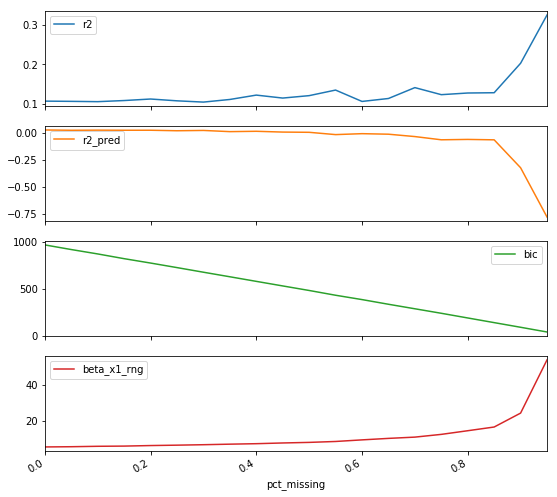

In [41]:
init_results[['r2', 'r2_pred', 
             'bic', 'beta_x1_rng']].plot(subplots=True, figsize=(9, 9))
